# Phoneme Classification

基于 [李宏毅ML2022SpringHomework](https://speech.ee.ntu.edu.tw/~hylee/ml/2022-spring.php) 。

## 项目说明

### 目标

使用 DNN 对语音序列进行 phoneme classification 。

### 数据预处理

数据集中的数据非原始音频数据，是从声谱中提取的 MFCC 特征，已经划分好了 frame 。

一般以 25 ms 为段长，以 10 ms 为步长，将音频分段（frame），相邻两段会重叠 15 ms ， 1 s 中有 100 个 frames 。

留有重叠部分是为了避免切分过度，丢失信息。

每个 frame 转化为一个 39 维的 MFCC feature vector 。

有些 phoneme 可能远不止 25 ms ，为了机器能够完整地识别到，将要预测的 frame 的前后，分别再各自多使用 5 个 frame 的信息。

即使用共 11 个 frame 的信息，预测其中间 frame 归属的类别。

对于某个 feature 开头和结尾的 frame ，分别用其结尾和开头的 frame 循环补充。

最后应该使用的 feature vector 是将这 11 个 frame 的信息 flatten 后的 11*39=429 维的向量。

### 数据集

使用 [LibriSpeech](https://www.openslr.org/12/) 数据集中的 train-clean-100 数据集的一部分。

- Training

    4268 段音频处理后的 feature ，以及对应的 label 序列，总共 2644158 个 frame 。

- Testing

    1078 段音频处理后的 feature ，总共 646268 个 frame 。

- Label

    共 41 个 class ，编号从 0 开始，每一个 class 代表一种 phoneme 。

### 文件说明

- `libriphone/train_split.txt`

    训练数据标识码

- `libriphone/train_labels`

    标识码及其对应的 label 序列。

- `libriphone/test_split.txt`

    测试数据标识码。

- `libriphone/feat/train/*.pt`

    训练数据标识码对应的 feature 文件，可读取为 shape: (Length of frames , 39) 的 Tensor 。

- `libriphone/feat/test/*.pt`

    测试数据标识码对应的 feature 文件。

## 导入包

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import os
import gc

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader

## 配置参数

In [11]:
class Config:
    # environment
    seed = 923
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_path_model = 'model.ckpt'
    save_path_predict = 'predict.csv'

    # local data path
    feature_path_train = 'libriphone/feat/train/'
    feature_path_test = 'libriphone/feat/test/'
    ID_path_train = 'libriphone/train_split.txt'
    ID_path_test = 'libriphone/test_split.txt'
    label_path = 'libriphone/train_labels.txt'
    
    # Kaggle data path
    here_path = os.getcwd()
    if 'kaggle/working' in here_path:      
        base = '../input/ml2022spring-hw2/libriphone/'
        feature_path_train = base + feature_path_train
        feature_path_test = base + feature_path_test
        ID_path_train = base + ID_path_train
        ID_path_test = base + ID_path_test
        label_path = base + label_path

    # data information
    dim_frame = 39
    n_frames = 11
    n_class = 41

    # NN strcture
    input_dim = dim_frame * n_frames # 39 * 11 = 429
    output_dim = n_class   # 41
    n_hidden_layer = 2
    hidden_dim = 256

    # training
    begin_example = 1
    n_example = math.inf
    n_epoch = 300
    early_stop_epoch = math.inf
    batch_size = 256
    learning_rate = 1e-4

    # mutiple step
    loading_step_size = 720
    n_loading_step = math.ceil(4268 / loading_step_size)

    # runing test
    runing_test = True
    if runing_test:
        begin_example = 1
        n_example = 20
        n_epoch = 5
        loading_step_size = 5
        n_loading_step = math.ceil(n_example / loading_step_size)

## 通用函数

In [12]:
def same_seed(seed): 
    torch.backends.cudnn.deterministic = True   # 卷积都使用默认的卷积算法
    torch.backends.cudnn.benchmark = False   # 关闭系统卷积算法选择优化（带随机性）
    np.random.seed(seed)   # 为随机算法设置种子。
    torch.manual_seed(seed)   # 为 CPU 设置种子。
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   # 为所有 GPU 设置种子。

def split_train_valid(data, valid_ratio, seed):
    valid_size = int(len(data) * valid_ratio)
    train_size = len(data) - valid_size
    train_set, valid_set = random_split(data, [train_size, valid_size], generator=torch.Generator().manual_seed(seed))
    # return np.array(train_set), np.array(valid_set)
    return train_set, valid_set

## 数据处理

In [13]:
def load_ID(path, begin_example):
    lines = []
    current_example = 0
    with open(path, 'r') as f:
        while True:
            line = f.readline()
            if line is None or line == '':
                break
            current_example += 1
            if current_example < begin_example:
                continue
            if current_example > Config.n_example or current_example - begin_example + 1 > Config.loading_step_size:
                break
            lines.append(line.strip('\n'))
    return lines

def combine_feature(feature):
    k = Config.n_frames // 2
    left_right_combine = torch.cat([feature[-k:], feature, feature[:k]])
    length = feature.shape[0]
    return [ left_right_combine[i:i + Config.n_frames].flatten() for i in range(length) ]

def process_feature(path, ID):   # load and combine feature
    res = []
    for id in ID:
        feature = torch.load(path + f'{id}.pt')
        feature = combine_feature(feature)
        res += feature
    return res

def label_to_vector(label):
    vec = torch.zeros(Config.n_class)
    vec[label] = 1
    return vec

def load_label(path, begin_example):
    res = []
    current_example = 0
    with open(path, 'r') as f:
        while True:
            line = f.readline()
            if line is None:
                break
            current_example += 1
            if current_example < begin_example:
                continue
            if current_example > Config.n_example or current_example - begin_example + 1 > Config.loading_step_size:
                break
            line = line.strip('\n').split(' ')
            label = [label_to_vector(int(x)) for x in line[1:]]
            res += label
    return res

class LibriDataset(Dataset):
    def __init__(self, x, y = None):
        self.data = x
        self.label = y

    def __getitem__(self, idx):
        if self.label is None:
            return self.data[idx]
        else:
            return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)

## 模型结构

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer(x)

class Classifier(nn.Module):
    def __init__(self, input_dim = Config.input_dim, output_dim = Config.output_dim, n_hidden_layer = Config.n_hidden_layer, hidden_dim = Config.hidden_dim):
        super().__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(Config.n_hidden_layer) ],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x) 

## 训练过程

In [15]:
def training(model, train_loader, valid_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)

    best_loss = math.inf
    early_stop_count = 0
    train_loss_per_epoch = []
    valid_loss_per_epoch = []

    for epoch in range(Config.n_epoch):
        
        model.train()
        train_loss_per_batch = []
        for batch in train_loader:
            feature, label = batch
            feature = feature.to(Config.device)
            label = label.to(Config.device)

            output = model(feature)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_per_batch.append(loss.item())
    
        train_mean_loss = np.mean(train_loss_per_batch)
        train_loss_per_epoch.append(train_mean_loss)
        
        model.eval()
        valid_loss_per_batch = []
        for batch in valid_loader:
            feature, label = batch
            feature = feature.to(Config.device)
            label = label.to(Config.device)

            output = model(feature)
            loss = criterion(output, label)

            valid_loss_per_batch.append(loss.item())
        
        early_stop_count += 1
        
        valid_mean_loss = np.mean(valid_loss_per_batch)
        valid_loss_per_epoch.append(valid_mean_loss)
        print(f'\r[{epoch + 1}/{Config.n_epoch}] train loss = {train_mean_loss:.4f}, valid loss = {valid_mean_loss:.4f}', end='')

        if valid_mean_loss < best_loss:
            best_loss = valid_mean_loss
            early_stop_count = 0
            torch.save(model.state_dict(), Config.save_path_model)
            print(f'\n[{epoch + 1}/{Config.n_epoch}] save model')
        if early_stop_count >= Config.early_stop_epoch:
            print(f'\n[{epoch + 1}/{Config.n_epoch}] early stop')
            break

    print(f'### best loss = {best_loss:.4f}')
    return train_loss_per_epoch, valid_loss_per_epoch, best_loss

## loss 曲线

In [16]:
def plot_loss(train_loss_per_epoch, valid_loss_per_epoch, best_loss):
    x = list(range(len(train_loss_per_epoch)))
    plt.figure()
    plt.xlabel('epoch * n_loading_step')
    plt.ylabel('loss')
    plt.plot(x, train_loss_per_epoch, 'g-', label='train loss')
    plt.plot(x, valid_loss_per_epoch, 'r--', label='valid loss')
    plt.legend()
    plt.show()

## 测试

In [17]:
def testing(model, test_loader):
    res = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            feature = batch
            feature = feature.to(Config.device)

            output = model(feature)
            predict = torch.argmax(output, dim=1)
            res += predict.tolist()
    
    res = pd.Series(res, name='Class')
    res.to_csv(Config.save_path_predict, index_label='Id')
    print('### predict result saved')


## main

begin_example = 1
[1/5] train loss = 3.6697, valid loss = 3.6245
[1/5] save model
[2/5] train loss = 3.5792, valid loss = 3.5158
[2/5] save model
[3/5] train loss = 3.4368, valid loss = 3.3289
[3/5] save model
[4/5] train loss = 3.2065, valid loss = 3.0310
[4/5] save model
[5/5] train loss = 2.9103, valid loss = 2.7736
[5/5] save model
### best loss = 2.7736
begin_example = 6
[1/5] train loss = 3.0887, valid loss = 3.0272
[1/5] save model
[2/5] train loss = 2.9652, valid loss = 2.9352
[2/5] save model
[3/5] train loss = 2.8581, valid loss = 2.8407
[3/5] save model
[4/5] train loss = 2.7426, valid loss = 2.7451
[4/5] save model
[5/5] train loss = 2.6234, valid loss = 2.6489
[5/5] save model
### best loss = 2.6489
begin_example = 11
[1/5] train loss = 2.8785, valid loss = 2.6926
[1/5] save model
[2/5] train loss = 2.7394, valid loss = 2.6042
[2/5] save model
[3/5] train loss = 2.6491, valid loss = 2.5227
[3/5] save model
[4/5] train loss = 2.5847, valid loss = 2.4484
[4/5] save model
[5/

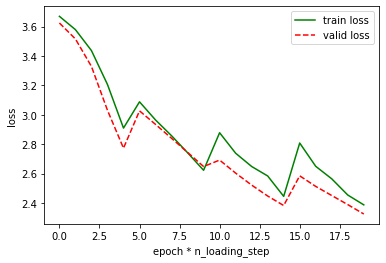

### predict result saved


In [18]:
def main():
    same_seed(Config.seed)
    
    model = Classifier().to(Config.device)
    begin_example = Config.begin_example
    train_loss_per_epoch, valid_loss_per_epoch, best_loss = [], [], math.inf
    while begin_example <= 4268 and begin_example <= Config.n_example:   # total examples
        print(f'begin_example = {begin_example}')
        ID_train = load_ID(Config.ID_path_train, begin_example)
        feature = process_feature(Config.feature_path_train, ID_train)
        label = load_label(Config.label_path, begin_example)
        
        feature_train, feature_valid = split_train_valid(feature, 0.2, Config.seed)   # have to use the same seed
        label_train, label_valid = split_train_valid(label, 0.2, Config.seed)   # have to use the same seed
        train_dataset = LibriDataset(feature_train, label_train)
        valid_dataset = LibriDataset(feature_valid, label_valid)
        train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size)
        
        a, b, c = training(model, train_loader, valid_loader)
        train_loss_per_epoch += a
        valid_loss_per_epoch += b
        best_loss = min(best_loss, c)

        del feature, label, \
            feature_train, feature_valid, \
            label_train, label_valid, \
            train_dataset, valid_dataset, \
            train_loader, valid_loader
        gc.collect()

        begin_example += Config.loading_step_size

    print('training stop')

    plot_loss(train_loss_per_epoch, valid_loss_per_epoch, best_loss)

    begin_example = 1
    Config.loading_step_size = Config.n_example   # loading_step_size may lower than n_example
    ID_test = load_ID(Config.ID_path_test, begin_example)
    feature_test = process_feature(Config.feature_path_test, ID_test)
    test_Dataset = LibriDataset(feature_test)
    test_loader = DataLoader(test_Dataset, batch_size=Config.batch_size)
    model.load_state_dict(torch.load(Config.save_path_model))
    testing(model, test_loader)

main()   # begin project